# Supplement (bonus) to Additional Task (CMS and E2E): Vision Transformers for End-to-End Particle Identification with the CMS Experiment
### Chenguang Guan

1. In the task-1 notebook ("E2E_and_CMS_task1_pytorch.ipynb") and the first additional task notebook ("E2E_and_CMS_Additional_Task_ViT.ipynb"), we have applied pre-trained ViT and Swin Transformer to the E2E classification problem.

2. In this notebook, we will compare ViT with MLP mixer, which is a supplement to the the first additional task notebook ("E2E_and_CMS_Additional_Task_ViT.ipynb").

## I. Preparation

In [ ]:
!/opt/bin/nvidia-smi

Sun Apr  2 14:20:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!cp --recursive "/content/gdrive/MyDrive/CMS_data" .

In [3]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.5 MB/s eta 0:00:00


In [4]:
import h5py
import torch

import numpy as np

from torch.utils.data import Dataset, DataLoader

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms


import random
import time

from sklearn import metrics

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [5]:
import matplotlib.pyplot as plt

In [6]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is:", device)

Device is: cuda


## II. Dataset

In [ ]:
shuffle_list = np.arange(0, 249000*2, 1) 
random.shuffle(shuffle_list)

In [ ]:
np.save("/content/gdrive/MyDrive/CMS_data/shuffle_list.npy",shuffle_list)

In [7]:
shuffle_list = np.load("/content/gdrive/MyDrive/CMS_data/shuffle_list.npy")

In [8]:
f1 = h5py.File(r'/content/CMS_data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
f2 = h5py.File(r'/content/CMS_data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
total_X = np.concatenate( (f1["X"][:], f2["X"][:] ), axis=0 )
total_y = np.concatenate( (f1["y"][:], f2["y"][:] ), axis=0 )

In [9]:
total_X = total_X[shuffle_list]
total_y = total_y[shuffle_list].astype(int)

In [10]:
class MyDataset(Dataset):
    def __init__(self, shuffle_list, train=True, transform=None, target_transform=None):
        global total_X, total_y
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.length = len(total_X)
        self.train_length = int( self.length * 9/10)
        self.test_length = int( self.length / 10)
            
    def __len__(self):
        if self.train:
            return self.train_length
        else:
            return self.test_length
    
    def __getitem__(self,idx):
        if self.train:
            image, label = total_X[idx], total_y[idx]
        else:
            image, label = total_X[idx + self.train_length], total_y[idx + self.train_length]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [11]:
my_transform_normal = transforms.ToTensor()

In [ ]:
my_transform_pretrained = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])

In [ ]:
my_transform_single_channel = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)),
                                   transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
    ])

In [12]:
train_set = MyDataset(shuffle_list=shuffle_list, train=True, transform=my_transform_normal)
train_loader =  DataLoader(train_set, batch_size=500, shuffle=True)

In [13]:
test_set = MyDataset(shuffle_list=shuffle_list, train=False, transform=my_transform_normal)
test_loader =  DataLoader(test_set, batch_size=500, shuffle=False)

## III. Train and Test Loop

In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    running_loss = 0.
    #total_sample = 0
    for batch_i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Compute prediction and loss
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        num_batch_print = 200
        if batch_i % num_batch_print == num_batch_print - 1:
            current = (batch_i + 1) * len(inputs)
            print(f'batch: [{batch_i + 1:5d}], loss: {running_loss / num_batch_print:.3f}')
            print(f'temporary loss: {loss.item():>7f} | [{current:>5d}/{size:>5d}]')
            running_loss = 0

In [14]:
def test_loop_Entropy(dataloader, model, loss_fn):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, correct = 0, 0
    total = 0
    
    with torch.no_grad():
        for data in dataloader:
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            
            # classify which class the output in
            _, predicted = torch.max(outputs.data, 1)
            #_, labels_value = torch.max(labels.data, 1)
            
            # obtain the statistics of test loss and correctness
            test_loss += loss_fn(outputs, labels).item()
            correct += (predicted == labels).sum().item() 
            #correct += (predicted == labels_value).sum().item() 
            total += labels.size(0)

    print(f"Test Error: \n Accuracy: {(100 * correct / total):>0.1f}%")
    print(f"Avg loss: {test_loss / num_batches:>8f} \n")
    return test_loss / num_batches

In [15]:
def test_loop_prob(dataloader, model):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    total_prob = list()
    total_label = list()
    i = 0
    with torch.no_grad():
        for (i, data) in enumerate(dataloader):
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)[:, 1]
            
            total_prob += torch.Tensor.cpu(probabilities).numpy().tolist()
            
            total_label += torch.Tensor.cpu(labels).numpy().tolist()
            
            if i % 25 == 0:
                print(f"Process: {i/num_batches*100}\%")
    return np.array(total_prob), np.array(total_label)

## III. ViT

The implementation is from https://github.com/lucidrains/vit-pytorch, where we change the prenorm to postnorm.

Batch size: 500

Training on: A100 GPU

Learning Rate: if the test loss isn't improved for three consecutive epochs, the learning rate will be reduced by a factor of ten.

Optimizer: Adam

Test Accuracy: 69.7% (Pre-norm); 69.9% (Post-norm)

ROC-AUC score: 0.76 (Post-norm)

The post-norm has slightly better performance.

In [30]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PostNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.norm( self.fn(x, **kwargs) )

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


### Pre-norm

In [35]:
class Transformer_pre(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [36]:
class ViT_pre(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer_pre(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

### Post-norm

In [37]:
class Transformer_post(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PostNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PostNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [38]:
class ViT_post(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer_post(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

### Training and Accuracy (ViT)

pre-norm

In [44]:
model_ViT = ViT_pre(image_size=32, patch_size=4, num_classes=2, dim=32, depth=6, heads=8, mlp_dim=128, pool="cls", channels=2, dim_head=32).to(device)

In [45]:
lr = 1e-3
optimizer = optim.Adam(model_ViT.parameters(), lr=lr)
lowest_loss = 1e4
count = 0
time_start = time.time()
for t in range( 20 ):
    print(f"-------------Epoch {t+1}-------------")
    print("current learning rate", lr)
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    train_loop(train_loader, model_ViT, criterion, optimizer)
    test_loss = test_loop_Entropy(test_loader, model_ViT, criterion)
    if int(test_loss * 100) < lowest_loss:
        lowest_loss = int(test_loss * 100)
        count = 0
    else:
        count += 1
    if count == 3:
        lr /= 10
        optimizer = optim.Adam(model_ViT.parameters(), lr=lr)
        count = 0
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
current learning rate 0.001
batch: [  200], loss: 0.692
temporary loss: 0.665314 | [100000/448200]
batch: [  400], loss: 0.668
temporary loss: 0.651435 | [200000/448200]
batch: [  600], loss: 0.655
temporary loss: 0.649895 | [300000/448200]
batch: [  800], loss: 0.645
temporary loss: 0.654485 | [400000/448200]
Test Error: 
 Accuracy: 62.8%
Avg loss: 0.654310 

-------------Epoch 2-------------
current learning rate 0.001
batch: [  200], loss: 0.633
temporary loss: 0.595667 | [100000/448200]
batch: [  400], loss: 0.632
temporary loss: 0.607458 | [200000/448200]
batch: [  600], loss: 0.623
temporary loss: 0.637537 | [300000/448200]
batch: [  800], loss: 0.622
temporary loss: 0.581627 | [400000/448200]
Test Error: 
 Accuracy: 66.0%
Avg loss: 0.625156 

-------------Epoch 3-------------
current learning rate 0.001
batch: [  200], loss: 0.615
temporary loss: 0.622645 | [100000/448200]
batch: [  400], loss: 0.617
temporary loss: 0.628382 | [200000/448200]
ba

In [46]:
path = "./gdrive/MyDrive/CMS_model/DIY_ViT_pre_norm_weights.pth"
torch.save(model_ViT.state_dict(), path)

In [ ]:
path = "./gdrive/MyDrive/CMS_model/DIY_ViT_pre_norm_weights.pth"
model_ViT.load_state_dict( torch.load(path) )

<All keys matched successfully>

Post-norm

In [48]:
model_ViT = ViT_post(image_size=32, patch_size=4, num_classes=2, dim=32, depth=6, heads=8, mlp_dim=128, pool="cls", channels=2, dim_head=32).to(device)

In [42]:
lr = 1e-3
optimizer = optim.Adam(model_ViT.parameters(), lr=lr)
lowest_loss = 1e4
count = 0
time_start = time.time()
for t in range( 20 ):
    print(f"-------------Epoch {t+1}-------------")
    print("current learning rate", lr)
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    train_loop(train_loader, model_ViT, criterion, optimizer)
    test_loss = test_loop_Entropy(test_loader, model_ViT, criterion)
    if int(test_loss * 100) < lowest_loss:
        lowest_loss = int(test_loss * 100)
        count = 0
    else:
        count += 1
    if count == 3:
        lr /= 10
        optimizer = optim.Adam(model_ViT.parameters(), lr=lr)
        count = 0
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
current learning rate 0.001
batch: [  200], loss: 0.690
temporary loss: 0.674187 | [100000/448200]
batch: [  400], loss: 0.664
temporary loss: 0.666566 | [200000/448200]
batch: [  600], loss: 0.653
temporary loss: 0.645730 | [300000/448200]
batch: [  800], loss: 0.645
temporary loss: 0.652268 | [400000/448200]
Test Error: 
 Accuracy: 64.4%
Avg loss: 0.636669 

-------------Epoch 2-------------
current learning rate 0.001
batch: [  200], loss: 0.634
temporary loss: 0.647865 | [100000/448200]
batch: [  400], loss: 0.632
temporary loss: 0.622703 | [200000/448200]
batch: [  600], loss: 0.627
temporary loss: 0.567416 | [300000/448200]
batch: [  800], loss: 0.626
temporary loss: 0.621813 | [400000/448200]
Test Error: 
 Accuracy: 66.2%
Avg loss: 0.622499 

-------------Epoch 3-------------
current learning rate 0.001
batch: [  200], loss: 0.622
temporary loss: 0.627090 | [100000/448200]
batch: [  400], loss: 0.618
temporary loss: 0.612087 | [200000/448200]
ba

In [43]:
path = "./gdrive/MyDrive/CMS_model/DIY_ViT_post_norm_weights01.pth"
torch.save(model_ViT.state_dict(), path)

In [50]:
path = "./gdrive/MyDrive/CMS_model/DIY_ViT_post_norm_weights01.pth"
model_ViT.load_state_dict( torch.load(path) )

<All keys matched successfully>

### ROC-AUC (ViT, post-norm)

In [51]:
total_prob_ViT, total_label_ViT = test_loop_prob(test_loader, model_ViT)
fpr, tpr, thresholds = metrics.roc_curve(total_label_ViT, total_prob_ViT)
ViT_AUC_1 = metrics.roc_auc_score(total_label_ViT, total_prob_ViT)

Process: 0.0\%
Process: 25.0\%
Process: 50.0\%
Process: 75.0\%


In [52]:
print("The ROC-AUC score of Post-norm ViTis:", ViT_AUC_1)

The ROC-AUC score of Post-norm ViTis: 0.7560649162172641


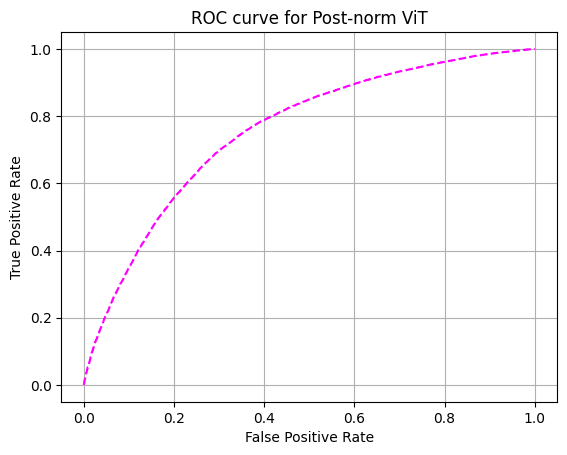

In [53]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Post-norm ViT")
plt.show()

## IV. MLP-mixer
The MLP-mixer architecture comes from https://arxiv.org/abs/2105.01601 . We implement this architecture.

Batch size: 200

Training on: A100 GPU

Learning Rate: if the test loss isn't improved for three consecutive epochs, the learning rate will be reduced by a factor of ten.

Optimizer: Adam

Test Accuracy: 70.0%

ROC-AUC score: 0.76

MLP-mixer has comparable performance with ViT.

In [16]:
train_set = MyDataset(shuffle_list=shuffle_list, train=True, transform=my_transform_normal)
train_loader =  DataLoader(train_set, batch_size=200, shuffle=True)

In [17]:
test_set = MyDataset(shuffle_list=shuffle_list, train=False, transform=my_transform_normal)
test_loader =  DataLoader(test_set, batch_size=200, shuffle=False)

In [18]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PostNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.norm( self.fn(x, **kwargs) )

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [19]:
class MixerBlock(nn.Module):
    def __init__(self, patch_dim, MLP_dim1):
        super().__init__()

        self.MLP1 = nn.Sequential(
            nn.Linear(patch_dim, MLP_dim1),
            nn.GELU(),
            nn.Linear(MLP_dim1, patch_dim),
        )

    def forward(self, x):

        x = rearrange(x, "b n p -> b p n")
        x = self.MLP1(x)
        x = rearrange(x, "b p n -> b n p")

        return x

class MLPBlock(nn.Module):
    def __init__(self, dim, MLP_dim2):
        super().__init__()

        self.MLP2 = nn.Sequential(
            nn.Linear(dim, MLP_dim2),
            nn.GELU(),
            nn.Linear(MLP_dim2, dim),
        )

    def forward(self, x):

        x = self.MLP2(x)

        return x

In [20]:
class Transformer_post(nn.Module):
    def __init__(self, dim, patch_dim, depth, MLP_dim1, MLP_dim2):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PostNorm(dim, MixerBlock(patch_dim, MLP_dim1) ),
                PostNorm(dim, MLPBlock(dim, MLP_dim2) )
            ]))
    def forward(self, x):
        for mixer, ff in self.layers:
            x = mixer(x) + x
            x = ff(x) + x
        return x

In [21]:
class MLP_mixer_post(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, MLP_dim1, MLP_dim2, pool = 'cls', channels = 3):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.transformer = Transformer_post(dim, num_patches + 1, depth, MLP_dim1, MLP_dim2)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [22]:
model_mixer = MLP_mixer_post(image_size=32, patch_size=4, num_classes=2, dim=32, depth=6, MLP_dim1=128, MLP_dim2=128, channels=2).to(device)

In [23]:
lr = 1e-3
optimizer = optim.Adam(model_mixer.parameters(), lr=lr)
lowest_loss = 1e4
count = 0
time_start = time.time()
for t in range( 20 ):
    print(f"-------------Epoch {t+1}-------------")
    print("current learning rate", lr)
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    train_loop(train_loader, model_mixer, criterion, optimizer)
    test_loss = test_loop_Entropy(test_loader, model_mixer, criterion)
    if int(test_loss * 100) < lowest_loss:
        lowest_loss = int(test_loss * 100)
        count = 0
    else:
        count += 1
    if count == 3:
        lr /= 10
        optimizer = optim.Adam(model_mixer.parameters(), lr=lr)
        count = 0
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
current learning rate 0.001
batch: [  200], loss: 0.698
temporary loss: 0.673596 | [40000/448200]
batch: [  400], loss: 0.676
temporary loss: 0.652516 | [80000/448200]
batch: [  600], loss: 0.662
temporary loss: 0.648319 | [120000/448200]
batch: [  800], loss: 0.655
temporary loss: 0.635867 | [160000/448200]
batch: [ 1000], loss: 0.653
temporary loss: 0.645348 | [200000/448200]
batch: [ 1200], loss: 0.650
temporary loss: 0.615312 | [240000/448200]
batch: [ 1400], loss: 0.645
temporary loss: 0.638919 | [280000/448200]
batch: [ 1600], loss: 0.641
temporary loss: 0.662458 | [320000/448200]
batch: [ 1800], loss: 0.640
temporary loss: 0.638867 | [360000/448200]
batch: [ 2000], loss: 0.636
temporary loss: 0.640229 | [400000/448200]
batch: [ 2200], loss: 0.635
temporary loss: 0.604948 | [440000/448200]
Test Error: 
 Accuracy: 64.9%
Avg loss: 0.636690 

-------------Epoch 2-------------
current learning rate 0.001
batch: [  200], loss: 0.632
temporary loss: 0.

### ROC-AUC (MLP-mixer, post-norm)

In [24]:
total_prob_mixer, total_label_mixer = test_loop_prob(test_loader, model_mixer)
fpr, tpr, thresholds = metrics.roc_curve(total_label_mixer, total_prob_mixer)
mixer_AUC_1 = metrics.roc_auc_score(total_label_mixer, total_prob_mixer)

Process: 0.0\%
Process: 10.040160642570282\%
Process: 20.080321285140563\%
Process: 30.120481927710845\%
Process: 40.16064257028113\%
Process: 50.20080321285141\%
Process: 60.24096385542169\%
Process: 70.28112449799197\%
Process: 80.32128514056225\%
Process: 90.36144578313254\%


In [25]:
print("The ROC-AUC score of MLP-mixer:", mixer_AUC_1)

The ROC-AUC score of MLP-mixer: 0.7592256588781701


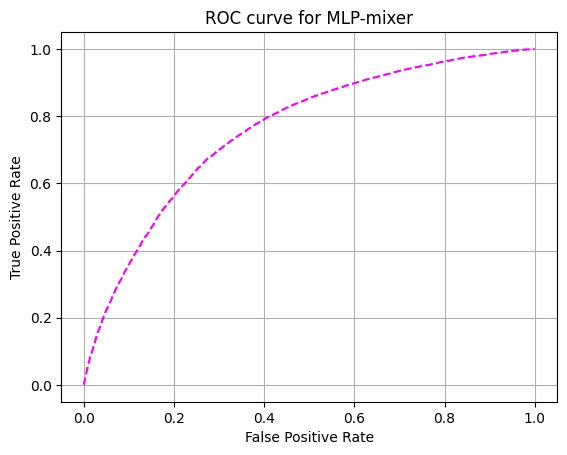

In [26]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for MLP-mixer")
plt.show()